<a href="https://colab.research.google.com/github/daveluo/covid19-healthsystemcapacity/blob/master/nbs/usa_beds_capacity_analysis_20200313_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [ ]:
!pip install us

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import shape
from urllib.request import urlopen 
import json
import os
from subprocess import call
from os.path import basename, isfile
from shutil import rmtree

In [3]:
def gdf_from_geojson(geojson, crs={'init':'epsg:4326'}):
    """Convert a GeoJSON dict to GeoDataFrame"""
    def _f(f):
        f['properties']['geometry'] = shape(f['geometry'])
        return f['properties']
    
    return gpd.GeoDataFrame([_f(f) for f in geojson['features']])

counties

In [4]:
with urlopen("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_20m.json") as url:
    data = json.loads(url.read().decode("ISO-8859-1"))
counties = gdf_from_geojson(data)

states

In [5]:
state_pop = pd.read_csv('http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv')

In [71]:
states

NameError: name 'states' is not defined

hr boundary

In [6]:
hr_bdry_file = 'https://atlasdata.dartmouth.edu/downloads/geography/hrr_bdry.zip'

In [28]:
if isfile(basename(hr_bdry_file)):
    os.remove(basename(hr_bdry_file))
if os.path.isdir('temp'):
    rmtree('temp')
call('wget {0} && mkdir temp && unzip {1} -d temp && rm {1} && mv temp/HRR_BDRY.DBF temp/HRR_Bdry.DBF'.format(hr_bdry_file, basename(hr_bdry_file)), shell=True)
hrr = gpd.read_file('temp/HRR_Bdry.SHP')
hrr.crs = 'epsg:4326'
rmtree('temp')

hospitals

In [66]:
hosp_gdf = gpd.read_file('../data/usa_facilities_hcris_geocoded.geojson')

In [70]:
gpd.read_file('../data/usa_hospital_beds_hcris2018_cleaned3.geojson').shape

(6661, 36)

aggregation

In [59]:
hosp_gdf.head()

,PROVIDER_NUMBER,FYB,FYE,STATUS,CTRL_TYPE,HOSP10_Name,Street_Addr,PO_Box,City,State,...,Coronary Care Unit Inpt Days,Burn ICU Inpt Days,Surgical ICU Inpt Days,Total Inpt Days,ICU Total Beds,ICU Total Bed Days Available,ICU Total Inpt Days,ICU Occupancy Rate,Total Bed Occupancy Rate,geometry
0,010001,01-OCT-17,30-SEP-18,As Submitted,9,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,...,0.0,0.0,0.0,95560.0,40.0,14600.0,11992.0,0.821370,0.800637,POINT (-85.36253 31.21591)
1,010005,01-OCT-17,30-SEP-18,As Submitted,9,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,None,BOAZ,AL,...,0.0,0.0,0.0,38089.0,20.0,7300.0,5283.0,0.723699,0.511536,POINT (-86.16006 34.22140)
2,010006,01-JUL-18,30-JUN-19,As Submitted,4,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,818,FLORENCE,AL,...,7515.0,0.0,0.0,61969.0,52.0,18368.0,13247.0,0.721200,0.594883,POINT (-87.65095 34.80439)
3,010007,01-OCT-17,30-SEP-18,As Submitted,9,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,...,0.0,0.0,0.0,4571.0,5.0,1825.0,1126.0,0.616986,0.278295,POINT (-86.25417 31.29198)
4,010008,01-JAN-18,31-DEC-18,As Submitted,4,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,...,0.0,0.0,0.0,1334.0,0.0,0.0,0.0,NaN,0.126027,POINT (-86.26472 31.69361)


In [50]:
hosp_gdf['Total Beds'].sort_values(ascending=False)

1025    2753.0
3900    2272.0
5537    1560.0
1024    1468.0
3958    1468.0
         ...  
6620       NaN
6627       NaN
6640       NaN
6650       NaN
6656       NaN
Name: Total Beds, Length: 6661, dtype: float64

In [51]:
hosp_gdf[['Total Beds', 'ICU Total Beds']].sum()

Total Beds        742562.0
ICU Total Beds     74688.0
dtype: float64

In [52]:
hosp_county_gdf = hosp_gdf.groupby(['State','County'], as_index='False')['ICU Total Beds', 'Total Beds'].sum().reset_index()

<ipython-input-52-d19c5432f5fb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hosp_county_gdf = hosp_gdf.groupby(['State','County'], as_index='False')['ICU Total Beds', 'Total Beds'].sum().reset_index()


In [53]:
hosp_county_gdf.head()

,State,County,ICU Total Beds,Total Beds
0,AK,ANCHORAGE,46.0,704.0
1,AK,BETHEL,0.0,34.0
2,AK,CORDOVA,0.0,13.0
3,AK,DILLINGHAM,0.0,18.0
4,AK,JUNEAU BOROUGH,9.0,45.0


In [54]:
# thank you https://eric.clst.org/tech/usgeojson/
!wget https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_20m.json

--2020-03-18 20:35:22--  https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_20m.json
Resolving eric.clst.org (eric.clst.org)... 69.163.226.135
Connecting to eric.clst.org (eric.clst.org)|69.163.226.135|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3436530 (3.3M) [application/json]
Saving to: ‘gz_2010_us_050_00_20m.json.1’

gz_2010_us_050_00_2 100%[===================>]   3.28M  2.84MB/s    in 1.2s    

2020-03-18 20:35:24 (2.84 MB/s) - ‘gz_2010_us_050_00_20m.json.1’ saved [3436530/3436530]



In [55]:
import json, os

us_county_path = 'gz_2010_us_050_00_20m.json'
cur_json = json.load(open(us_county_path, encoding='ISO-8859-1'))

path,ext = os.path.splitext(us_county_path)
new_path =path+"_new"+ext
with open(new_path,"w", encoding='utf-8') as jsonfile:
        json.dump(cur_json,jsonfile,ensure_ascii=False)
us_county = gpd.read_file(new_path, driver='GeoJSON')

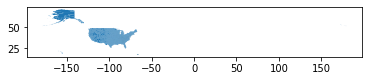

In [56]:
us_county.plot()

In [65]:
hosp_gdf[hosp_gdf['State'] == 'MP']

,PROVIDER_NUMBER,FYB,FYE,STATUS,CTRL_TYPE,HOSP10_Name,Street_Addr,PO_Box,City,State,...,Coronary Care Unit Inpt Days,Burn ICU Inpt Days,Surgical ICU Inpt Days,Total Inpt Days,ICU Total Beds,ICU Total Bed Days Available,ICU Total Inpt Days,ICU Occupancy Rate,Total Bed Occupancy Rate,geometry
6529,660001,01-OCT-17,30-SEP-18,As Submitted,13,COMMONWEALTH HEALTH CENTER,LOWER NAVY HILL RD,409 CK,SAIPAN,MP,...,0.0,0.0,0.0,17728.0,4.0,1460.0,918.0,0.628767,0.65635,POINT (145.72000 15.21000)


In [ ]:
hosp_gdf_countyjoin = gpd.sjoin(hosp_gdf, us_county, how='inner', op='intersects')
hosp_gdf_countyjoin.head()

In [ ]:
hosp_county_gdf = hosp_gdf_countyjoin.groupby(['STATE','COUNTY','GEO_ID'], as_index='False')['ICU Total Beds', 'Total Beds','Total Bed Days Available','Total Inpt Days', 'ICU Total Bed Days Available', 'ICU Total Inpt Days'].sum().reset_index()

In [ ]:
hosp_county_gdf.shape

In [ ]:
hosp_county_gdf = pd.merge(hosp_county_gdf, us_county)
hosp_county_gdf['ICU Occupancy Rate'] = hosp_county_gdf['ICU Total Inpt Days']/hosp_county_gdf['ICU Total Bed Days Available']
hosp_county_gdf['Total Bed Occupancy Rate'] = hosp_county_gdf['Total Inpt Days']/hosp_county_gdf['Total Bed Days Available']

In [ ]:
hosp_county_gdf.head()

In [ ]:
hosp_county_gdf = gpd.GeoDataFrame(hosp_county_gdf, crs=4326)
hosp_county_gdf.plot(figsize=(15,15))

In [ ]:
# get latest census data for population demographics by us county at https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html
# data description here: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/cc-est2018-alldata.pdf

!wget https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/counties/asrh/cc-est2018-alldata.csv

In [ ]:
census_df = pd.read_csv('cc-est2018-alldata.csv', encoding='unicode_escape')

In [ ]:
census_df.head()

In [ ]:
census_df['fips_code'] = census_df['STATE'].apply(lambda x: str(x).zfill(2)) + census_df['COUNTY'].apply(lambda x: str(x).zfill(3))

In [ ]:
census_df.head()

In [ ]:
# YEAR 11 = 7/1/2018 population estimate
census_df[census_df['YEAR'] == 11].head()

In [ ]:
census2018_df = census_df[census_df['YEAR'] == 11]

In [ ]:
# pop of 15+ year olds by county
# AGEGRP 4 = Age 15 to 19 years
# AGEGRP 0 = All, need to exclude or double counts
adult_totpop_countywise = census2018_df[census2018_df['AGEGRP']>=4].groupby(['fips_code'])['TOT_POP'].sum()
all_totpop_countywise = census2018_df[census2018_df['AGEGRP']>=1].groupby(['fips_code'])['TOT_POP'].sum()

In [ ]:
adult_totpop_countywise.sum(), all_totpop_countywise.sum() 

In [ ]:
adult_totpop_countywise

In [ ]:
hosp_county_gdf.shape

In [ ]:
hosp_county_gdf['fips_code'] = hosp_county_gdf['GEO_ID'].apply(lambda x: x[-5:])

In [ ]:
hosp_county_census_gdf = hosp_county_gdf.join(adult_totpop_countywise, how='inner', on='fips_code')
hosp_county_census_gdf.rename({'TOT_POP':'15 and Older Population'}, axis=1, inplace=True)

In [ ]:
hosp_county_census_gdf = hosp_county_census_gdf.join(all_totpop_countywise, how='inner', on='fips_code')
hosp_county_census_gdf.rename({'TOT_POP':'All Population'}, axis=1, inplace=True)

In [ ]:
hosp_county_census_gdf.head()

In [ ]:
hosp_county_census_gdf['ICU Beds per 1000 Adults (15+)'] = hosp_county_census_gdf['ICU Total Beds']/(hosp_county_census_gdf['15 and Older Population']/1000)
hosp_county_census_gdf['Total Beds per 1000 Adults (15+)'] = hosp_county_census_gdf['Total Beds']/(hosp_county_census_gdf['15 and Older Population']/1000)
hosp_county_census_gdf['ICU Beds per 1000 People'] = hosp_county_census_gdf['ICU Total Beds']/(hosp_county_census_gdf['All Population']/1000)
hosp_county_census_gdf['Total Beds per 1000 People'] = hosp_county_census_gdf['Total Beds']/(hosp_county_census_gdf['All Population']/1000)
hosp_county_census_gdf.head()

In [ ]:
# sanity check
hosp_county_census_gdf['ICU Total Beds'].sum() / (hosp_county_census_gdf['All Population'].sum()/100000)

In [ ]:
hosp_county_census_gdf['Total Beds'].sum() / (hosp_county_census_gdf['All Population'].sum()/1000)

## Check bed stats against:

https://www.kff.org/other/state-indicator/beds-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

- 2.4 staffed beds per 1,000 pop across USA

https://www.sccm.org/Communications/Critical-Care-Statistics

AHA data: According to the AHA 2015 annual survey, the United States had 
- 4862 acute care registered hospitals; 
  - 2814 of these had at least 10 acute care beds and at least 1 ICU bed. 
- These hospitals had a total of 540,668 staffed beds and 94,837 ICU beds (14.3% ICU beds/total beds) in 5229 ICUs. 
  - There were 46,490 medical-surgical beds in 2644 units, 
  - 14,731 cardiac beds in 976 units, 
  - 6588 other beds in 379 units, 
  - 4698 pediatric beds in 307 units, and 
  - 22,330 neonatal beds in 920 units. 
- The median number of beds in medical-surgical, cardiac, and other units was 12, with 10 beds in pediatrics and 18 in neonatal. Fifty-two percent of hospitals had 1 unit, 24% had 2 units, and 24% had 3 or more units.

HCRIS data: 
- In 2010 there were 2977 acute care hospitals with ICU beds. 
- In these, there were 641,395 total acute care beds with 103,900 ICU beds (16.2% ICU beds/total beds). 
- From 2000 to 2010, the number of critical care beds in the United States increased by 17.8%, from 88,235 to 103,900. However, the majority of the growth in critical care bed supply is occurring in a small number of U.S. regions that tend to have large populations, fewer baseline ICUs per 100,000 capita, higher baseline ICU occupancy, and increased market competition. Additionally, between 2000 and 2010, the greatest percentage increases were in neonatal beds (29%), followed by adult beds (26%); there were minimal changes in pediatric beds (2.7%). 
- Of the 103,900 ICU beds in 2010, 
  - 83,417 (80.3%) were adult, 
  - 1917 (1.8%) were pediatric, and 
  - 18,567 (17.9%) were neonatal. 
- In total, there were 33.6 beds per 100,000 population, 
  - 35.5 beds per 100,000 adult beds (age > 18 years), 
  - 2.7 beds/100,000 pediatric beds (age 1-17 years), 
  - and 470 beds/100,000 neonatal beds (age < 1 year).

ICU days: HCRIS analysis showed that there were 150.9 million hospital days, including 25 million ICU days in 2010 (16.5% ICU days/total days). Medicare accounted for 7.9 million ICU days (31.4%) and Medicaid 4.3 million ICU days (17.2%).

Occupancy: Occupancy rates were calculated from HCRIS (days/possible days) data. In 2010, hospital and ICU occupancy rates were 64.6% and 68%, respectively. Occupancy rates vary by hospital size, with higher occupancy rates associated with larger hospitals.

In [ ]:
hosp_county_census_gdf.to_file('usa_county_hospital_bedcapacity2018.geojson', driver='GeoJSON')

In [ ]:
hosp_county_census_gdf.to_csv('usa_county_hospital_bedcapacity2018.csv')